In [1]:
%matplotlib inline

from IPython import display
import io
import time

import logging
import glob

import matplotlib.pyplot as plt
import cv2
import boto3
from botocore.exceptions import ClientError
from sagemaker.predictor import Predictor
import sagemaker, json
from sagemaker import get_execution_role

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

import octank_utility as utility

logger = logging.getLogger(__name__)

### Initialize general parameters

In [2]:
role = get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session()

bucket = sess.default_bucket()
account = sess.account_id()


prefix = 'octank_videos'

test_image = 'synthetic_data_106.jpg'

video_path = glob.glob('../4-rekognition/videos/*.mp4')[0]

s3 = boto3.client('s3')
object_name = f"{prefix}/{video_path.split('/')[-1]}"

response = s3.upload_file(video_path, bucket, object_name)

s3_path = f"s3://{bucket}/{object_name}"
print(s3_path)

s3://sagemaker-us-west-2-420618410968/octank_videos/movie-6288050.mp4


### Initialize parameters for Rekognition Object detection

In [7]:
project_arn='arn:aws:rekognition:us-west-2:420618410968:project/octank-demo-ab3/1656765474143'
model_arn='arn:aws:rekognition:us-west-2:420618410968:project/octank-demo-ab3/'+\
            'version/octank-demo-ab3.2022-07-02T07.46.31/1656765991230'

version_name='octank-demo-ab3.2022-07-02T07.46.31'

rekognition = boto3.client('rekognition')

### Initialize parameters for embedding search

In [9]:
# SageMaker endpoint
embedding_endpoint = 'jumpstart-example-infer-tensorflow-icem-2022-06-21-17-42-58-843'

# embedding model predictor
model_predictor = Predictor(endpoint_name = embedding_endpoint,
                           sagemaker_session = sess)


# Opensearch
opensearch_domain_endpoint = 'search-jingswu-ab-image-search-objkrip5ozc6tafoc7qnnkkhpq.us-west-2.es.amazonaws.com'

index_name = 'image_embedding'

credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region)

opensearch_host = {
    'host' : opensearch_domain_endpoint,
    'port' : 443,
    'scheme' : 'https',
}

opensearch = OpenSearch(hosts = [opensearch_host],
               http_auth = auth,
                use_ssl = True,
                verify_certs = True,
                connection_class = RequestsHttpConnection)

### Initialize for DynamoDB

In [10]:
table_name = 'octank_movie'

dynamodb = boto3.resource('dynamodb')

## Becareful.  ONLY RUN THIS IF YOU ARE DONE

In [ ]:
def stop_rekognition_model(client, model_arn):

    print('Stopping model:' + model_arn)

    #Stop the model
    try:
        response=client.stop_project_version(ProjectVersionArn=model_arn)
        status=response['Status']
        print ('Status: ' + status)
    except Exception as e:  
        print(e)  

    print('Done...')

# stop_rekognition_model(rekognition, model_arn)

## Host Rekognition model

In [11]:
def start_rekognition_model(client, model_arn, project_arn, version_name, min_inference_units=1):   
    try:
        # Start the model
        logger.info('Starting model: ' + model_arn)
        response=client.start_project_version(ProjectVersionArn=model_arn, MinInferenceUnits=min_inference_units)
        # Wait for the model to be in the running state
        project_version_running_waiter = client.get_waiter('project_version_running')
        project_version_running_waiter.wait(ProjectArn=project_arn, VersionNames=[version_name])

        #Get the running status
        describe_response=client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            logger.info("Status: " + model['Status'])
            logger.info("Message: " + model['StatusMessage'])
    
    except Exception as e:
        logger.error(e)

    return model['Status']

# Check if Rokognition model is running

In [12]:
try:
    describe_response = rekognition.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])

    if len(describe_response['ProjectVersionDescriptions'])<1:
        logger.error('No model found..................')
        raise

    model = describe_response['ProjectVersionDescriptions'][0]

    status = model['Status']

    if status != "RUNNING":
        status = start_rekognition_model(rekognition, 
                                         model_arn, 
                                         project_arn, 
                                         version_name,
                                         1)
    
except ClientError as client_err:
    logger.error(format(client_err))
    raise
    
print(status)

RUNNING


# Load a frame and send to Rekognition model

In [21]:
from ipywidgets import widgets, HBox, VBox

def display_results(results):
    Vbox_list = []
    for distance, product_id, category in results:
        Vbox_list.append(VBox([widgets.Label(f"Score: {distance:.2f}"),
                               widgets.Label(f"Product ID: {product_id}"),
                               widgets.Label(f"Category: {category}"),
                               widgets.Image(value=open(f"../2-opensearch/images/{product_id}.jpg", 'rb').read())]))
    hbox = HBox(Vbox_list)
    display.display(hbox)

frame1 = cv2.imread(test_image)

height = frame1.shape[0]
width = frame1.shape[1]

image_bytes = cv2.imencode('.jpg', frame1)[1].tobytes()

results = utility.analyze_video_frame(rekognition, 
                             model_arn, 
                            image_bytes,
                            80)

## Evaluate model results

[[148.03165, '134b991a-f336-4b73-ae44-247317af0130', 'apparel']]


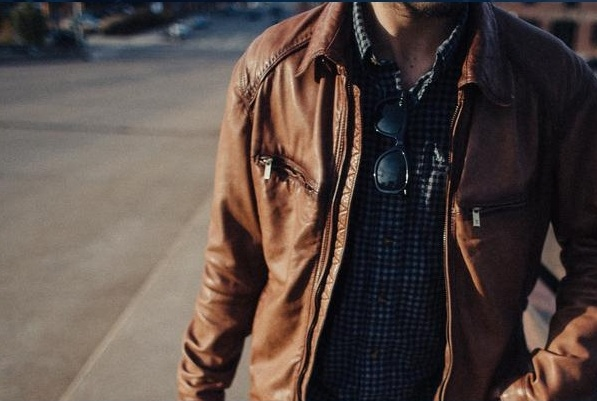

[[170.67007, '8d4ea20c-19e5-4bc8-bdb3-7168e89bb176', 'jewelry']]


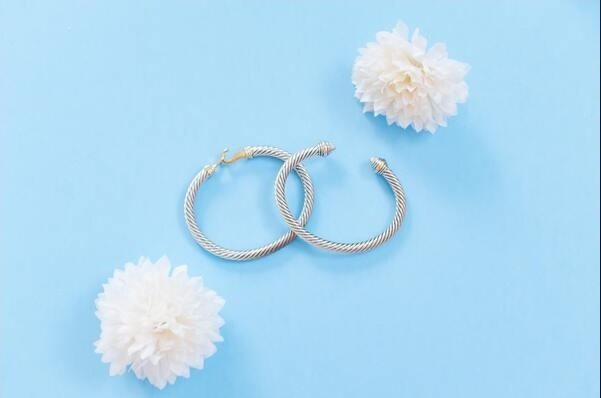

[[226.0256, '59b0aeff-c1cc-4d7c-b928-dec5457942e0', 'beauty']]


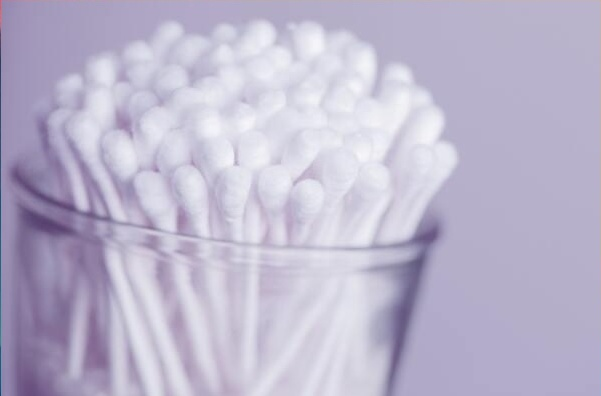

In [22]:
for product in results:
    cropped, bbox = utility.crop_images(frame1, product['Geometry']['BoundingBox'])
    
    cropped_bytes = cv2.imencode('.jpeg', cropped)[1].tobytes()
#     display.display(display.Image(data=cropped_bytes))
    
    embedding_vector = utility.generate_embedding(cropped_bytes, model_predictor)
    
    search_results = utility.knn_search(opensearch, index_name, 1, embedding_vector)
    
    print(search_results)
    
    
    display.display(display.Image(data=cropped_bytes))

    display_results(search_results)

## Create function to process video frames

In [23]:
def process_frames(frame):
    
    # get width and height info for each frame
    height = frame.shape[0]
    width = frame.shape[1]
    
    # send frame to Rekognition for inference

    image_bytes = cv2.imencode('.jpg', frame)[1].tobytes()
    results = utility.analyze_video_frame(rekognition, 
                                 model_arn, 
                                image_bytes,
                                80)
    
    detections = []
    for product in results:
        
        detect =dict()

        # crop images
        cropped, bbox = utility.crop_images(frame1, product['Geometry']['BoundingBox'])
    
        detect['bbox']=bbox

        cropped_bytes = cv2.imencode('.jpeg', cropped)[1].tobytes()

        # generate embedding
        embedding_vector = utility.generate_embedding(cropped_bytes, model_predictor)
        
        # search product info from OpenSearch
        results = utility.knn_search(opensearch, index_name, 1, embedding_vector)
        
        print(results)
        detect['product_id'] = results[0][1]
        detect['product_category'] = results[0][2]
        
        detections.append(detect)
    
    
    return detections
    
process_frames(frame1)

[[148.03165, '134b991a-f336-4b73-ae44-247317af0130', 'apparel']]
[[170.67007, '8d4ea20c-19e5-4bc8-bdb3-7168e89bb176', 'jewelry']]
[[226.0256, '59b0aeff-c1cc-4d7c-b928-dec5457942e0', 'beauty']]


[{'bbox': {'top': 1227, 'bottom': 1628, 'left': 585, 'right': 1182},
  'product_id': '134b991a-f336-4b73-ae44-247317af0130',
  'product_category': 'apparel'},
 {'bbox': {'top': 1556, 'bottom': 1954, 'left': 3207, 'right': 3808},
  'product_id': '8d4ea20c-19e5-4bc8-bdb3-7168e89bb176',
  'product_category': 'jewelry'},
 {'bbox': {'top': 1218, 'bottom': 1614, 'left': 1471, 'right': 2072},
  'product_id': '59b0aeff-c1cc-4d7c-b928-dec5457942e0',
  'product_category': 'beauty'}]

In [26]:
from IPython.display import HTML
from base64 import b64encode
import cv2
import time

table = dynamodb.Table(table_name)
# check if Rekognition model is running, if not start...

# download image from s3
ready = utility.check_rekognition_model_status(rekognition,
                                       project_arn,
                                       version_name)

if ready:
    output = dict()
    
    #download file frame s3
    s3.download_file(bucket, object_name, video_path)

    
    output['video_id'] = video_path.split('/')[-1]
    output['detections'] = dict()
    # load the movie video
    cap = cv2.VideoCapture(video_path)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print('Frame count:', frame_count)
    frame_id = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
#     # print('Position:', cap.get(cv2.CAP_PROP_POS_FRAMES))

    display_handle=display.display(None, display_id=True)

    try:
        while True:
            _, frame = cap.read()
            
            detections = process_frames(frame)
            
            for d in detections:
                frame = utility.draw_bbox(cv2, frame, d['bbox'])
            
#             _, frame = cv2.imencode('.jpeg', frame)
#             display_handle.update(display.Image(data=frame.tobytes()))
#             time.sleep(2)

            output['detections'][str(frame_id)] = detections
            frame_id += 1
            if frame_id >= frame_count:
                break
        table.put_item(
            Item=output
        )
    except KeyboardInterrupt:
        pass
    finally:
        cap.release()
        display_handle.update(None)

None

[[23.511642, '7cd4cc5b-4302-40ee-989a-078559761ef8', 'outdoors']]
[[23.629978, '7cd4cc5b-4302-40ee-989a-078559761ef8', 'outdoors']]
[[33.43637, '9530f9fb-ebbe-4da4-9530-d728053c23ca', 'accessories']]
[[33.43637, '9530f9fb-ebbe-4da4-9530-d728053c23ca', 'accessories']]
[[61.593357, '26fd5578-6417-4b0a-a416-bd43083eec22', 'apparel']]
[[23.629978, '7cd4cc5b-4302-40ee-989a-078559761ef8', 'outdoors']]
[[40.750065, '9e90d949-90f7-443a-8a85-fa7e590bc589', 'apparel']]
[[85.10948, '134b991a-f336-4b73-ae44-247317af0130', 'apparel']]
[[34.153862, '53c51962-3546-4c9c-b88e-fe287c94782f', 'footwear']]
[[40.750065, '9e90d949-90f7-443a-8a85-fa7e590bc589', 'apparel']]
[[73.14471, '33308fd7-d70d-4b2a-a897-f3313609e86b', 'seasonal']]
[[33.43637, '9530f9fb-ebbe-4da4-9530-d728053c23ca', 'accessories']]
[[73.14471, '33308fd7-d70d-4b2a-a897-f3313609e86b', 'seasonal']]
[[97.00655, '134b991a-f336-4b73-ae44-247317af0130', 'apparel']]
[[40.073368, '9e90d949-90f7-443a-8a85-fa7e590bc589', 'apparel']]
[[53.68923, '9

## Test processing script

In [27]:
from sagemaker.tensorflow import TensorFlowProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role

#Initialize the TensorFlowProcessor
tp = TensorFlowProcessor(
    framework_version='2.3',
    role=get_execution_role(),
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='octank-test',
    py_version='py37'
)

In [28]:
#Run the processing job
tp.run(
    code='video_processing.py',
    arguments=["--filename", s3_path.split('/')[-1]],
    source_dir='src',
    inputs=[
        ProcessingInput(
            source=s3_path,
            destination='/opt/ml/processing/input'
        )
    ]
)


Job Name:  octank-test-2022-07-04-13-38-03-925
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-420618410968/octank_videos/movie-6288050.mp4', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-420618410968/octank-test-2022-07-04-13-38-03-925/source/sourcedir.tar.gz', 'LocalPath': '/opt/ml/processing/input/code/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'entrypoint', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-420618410968/octank-test-2022-07-04-13-38-03-925/source/runproc.sh', 'LocalPath': '/opt/ml/processing/input/entrypoint', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyR

## Build docker image for Lambda execution

In [10]:
!rm -rf docker
!mkdir docker

In [11]:
%%writefile docker/requirements.txt
opensearch-py
opencv-python
boto3
sagemaker
requests

Writing docker/requirements.txt


In [12]:
%%writefile docker/Dockerfile

FROM public.ecr.aws/docker/library/python:3.7
    
ADD requirements.txt /
ADD video_processing.py /
ADD octank_utility.py /

RUN apt-get update
RUN apt-get install ffmpeg libsm6 libxext6  -y
RUN pip3 install -r requirements.txt

ENV PYTHONUNBUFFERED=TRUE 
ENV TF_CPP_MIN_LOG_LEVEL="2"

ENTRYPOINT ["python3", "/video_processing.py"]

Writing docker/Dockerfile


In [34]:
!pip install sagemaker-studio-image-build

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
  Using cached botocore-1.26.10-py3-none-any.whl (8.8 MB)
  Created wheel for sagemaker-studio-image-build: filename=sagemaker_studio_image_build-0.6.0-py3-none-any.whl size=13469 sha256=0cb20d690eb9a4c9af4f5a229bbaad2eace3ef469e4d56149eec7a49659a01d1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ee/a3/ba/fa5677c340fe6a76f3f39cb3e9823726f994c5d481658bb089
Successfully built sagemaker-studio-image-build
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.26.10 which is incompatible.
You should c

In [13]:
!cp src/video_processing.py docker/video_processing.py
!cp src/octank_utility.py docker/octank_utility.py

In [14]:
container_name = "sagemaker-tf-container"
!cd docker && sm-docker build . --file Dockerfile --repository $container_name:2.0
    
ecr_image = "{}.dkr.ecr.{}.amazonaws.com/{}:2.0".format(account, region, container_name)

....[Container] 2022/07/04 14:08:04 Waiting for agent ping

[Container] 2022/07/04 14:08:05 Waiting for DOWNLOAD_SOURCE
[Container] 2022/07/04 14:08:09 Phase is DOWNLOAD_SOURCE
[Container] 2022/07/04 14:08:09 CODEBUILD_SRC_DIR=/codebuild/output/src387740688/src
[Container] 2022/07/04 14:08:09 YAML location is /codebuild/output/src387740688/src/buildspec.yml
[Container] 2022/07/04 14:08:09 Setting HTTP client timeout to higher timeout for S3 source
[Container] 2022/07/04 14:08:09 Processing environment variables
[Container] 2022/07/04 14:08:09 No runtime version selected in buildspec.
[Container] 2022/07/04 14:08:09 Moving to directory /codebuild/output/src387740688/src
[Container] 2022/07/04 14:08:09 Configuring ssm agent with target id: codebuild:77e08584-6200-4142-a317-57525d7b5c6b
[Container] 2022/07/04 14:08:09 Successfully updated ssm agent configuration
[Container] 2022/07/04 14:08:09 Registering with agent
[Container] 2022/07/04 14:08:09 Phases found in YAML: 3
[Container] 2022/

Selecting previously unselected package libllvm11:amd64.
Preparing to unpack .../104-libllvm11_1%3a11.0.1-2_amd64.deb ...
Unpacking libllvm11:amd64 (1:11.0.1-2) ...
Selecting previously unselected package libsensors-config.
Preparing to unpack .../105-libsensors-config_1%3a3.6.0-7_all.deb ...
Unpacking libsensors-config (1:3.6.0-7) ...
Selecting previously unselected package libsensors5:amd64.
Preparing to unpack .../106-libsensors5_1%3a3.6.0-7_amd64.deb ...
Unpacking libsensors5:amd64 (1:3.6.0-7) ...
Selecting previously unselected package libvulkan1:amd64.
Preparing to unpack .../107-libvulkan1_1.2.162.0-1_amd64.deb ...
Unpacking libvulkan1:amd64 (1.2.162.0-1) ...
Selecting previously unselected package libgl1-mesa-dri:amd64.
Preparing to unpack .../108-libgl1-mesa-dri_20.3.5-1_amd64.deb ...
Unpacking libgl1-mesa-dri:amd64 (20.3.5-1) ...
Selecting previously unselected package libglx-mesa0:amd64.
Preparing to unpack .../109-libglx-mesa0_20.3.5-1_amd64.deb ...
Unpacking libglx-mesa0:a

Setting up libdrm2:amd64 (2.4.104-1) ...
Setting up libflite1:amd64 (2.2-2) ...
Setting up libva-drm2:amd64 (2.10.0-1) ...
Setting up libsord-0-0:amd64 (0.16.8-2) ...
Setting up libwayland-cursor0:amd64 (1.18.0-2~exp1.1) ...
Setting up libsratom-0-0:amd64 (0.6.8-1) ...
Setting up libsndfile1:amd64 (1.0.31-2) ...
Setting up libva-x11-2:amd64 (2.10.0-1) ...
Setting up liblilv-0-0:amd64 (0.24.12-2) ...
Setting up libopenmpt0:amd64 (0.4.11-1) ...
Setting up libdrm-amdgpu1:amd64 (2.4.104-1) ...
Setting up mesa-vulkan-drivers:amd64 (20.3.5-1) ...
Setting up libdrm-nouveau2:amd64 (2.4.104-1) ...
Setting up libgbm1:amd64 (20.3.5-1) ...
Setting up libpulse0:amd64 (14.2-2) ...
Setting up libdrm-radeon1:amd64 (2.4.104-1) ...
Setting up libdrm-intel1:amd64 (2.4.104-1) ...
Setting up libgl1-mesa-dri:amd64 (20.3.5-1) ...
Setting up libopenal1:amd64 (1:1.19.1-2) ...
Setting up libavutil56:amd64 (7:4.3.4-0+deb11u1) ...
Setting up libpostproc55:amd64 (7:4.3.4-0+deb11u1) ...
Setting up libswscale5:amd64

Removing intermediate container e137a5118111
 ---> 01bebf534511
Step 8/10 : ENV PYTHONUNBUFFERED=TRUE
 ---> Running in 5739d6c90eee
Removing intermediate container 5739d6c90eee
 ---> 1c47a7778ae2
Step 9/10 : ENV TF_CPP_MIN_LOG_LEVEL="2"
 ---> Running in 6bcd2d299983
Removing intermediate container 6bcd2d299983
 ---> 3a02febcedce
Step 10/10 : ENTRYPOINT ["python3", "/video_processing.py"]
 ---> Running in 4ad1c434da9b
Removing intermediate container 4ad1c434da9b
 ---> 269ca4e9406e
Successfully built 269ca4e9406e
Successfully tagged sagemaker-tf-container:2.0

[Container] 2022/07/04 14:09:38 Running command docker tag $IMAGE_REPO_NAME:$IMAGE_TAG $AWS_ACCOUNT_ID.dkr.ecr.$AWS_DEFAULT_REGION.amazonaws.com/$IMAGE_REPO_NAME:$IMAGE_TAG

[Container] 2022/07/04 14:09:38 Phase complete: BUILD State: SUCCEEDED
[Container] 2022/07/04 14:09:38 Phase context status code:  Message:
[Container] 2022/07/04 14:09:38 Entering phase POST_BUILD
[Container] 2022/07/04 14:09:38 Running command echo Build comp

In [15]:
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput

processor = Processor(image_uri=ecr_image,
                     role=role,
                     instance_count=1,
                     instance_type="ml.m5.xlarge")

processor.run(arguments=["--filename", s3_path.split('/')[-1]],
              inputs=[
                ProcessingInput(
                    source=s3_path,
                    destination='/opt/ml/processing/input'
                )])


Job Name:  sagemaker-tf-container-2022-07-04-14-12-59-238
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-420618410968/octank_videos/movie-6288050.mp4', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  []
.........................['movie-6288050.mp4']
An error occurred (InvalidParameterException) when calling the DescribeProjectVersions operation: Cross account access not allowed
Finished running processing job



## Code to execute from lambda

In [16]:
sagemaker = boto3.client('sagemaker')


response = sagemaker.create_processing_job(
    ProcessingInputs=[
        {
            'InputName': 's3_video_input',
            'S3Input': {
                'S3Uri': s3_path,
                'LocalPath': '/opt/ml/processing/input',
                'S3DataType': 'S3Prefix',
                'S3InputMode':'File'
                
            }
        },
    ],
    ProcessingJobName='octank-video-processing-3',
    ProcessingResources={
        'ClusterConfig': {
            'InstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
            'VolumeSizeInGB': 30,
        }
    },
    AppSpecification={
        'ImageUri': ecr_image,
        'ContainerArguments': ["--filename", s3_path.split('/')[-1]]
    },
    RoleArn=role,
    Tags=[
        {
            'Key': 'project',
            'Value': 'awsome-builder'
        },
    ]
)

In [17]:
response

{'ProcessingJobArn': 'arn:aws:sagemaker:us-west-2:420618410968:processing-job/octank-video-processing-3',
 'ResponseMetadata': {'RequestId': 'dd507c97-9564-45b3-b2f9-7f82175eb56c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'dd507c97-9564-45b3-b2f9-7f82175eb56c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '104',
   'date': 'Mon, 04 Jul 2022 14:42:42 GMT'},
  'RetryAttempts': 0}}